In [2]:
!pip install tensorflow keras

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Metrics and Evaluation Tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Libraries imported successfully!")


Libraries imported successfully!


In [8]:
# Set a seed value
seed_value = 42

# 1. Set PYTHONHASHSEED environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set python built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set numpy pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set TensorFlow pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. If using Dropout, specify a seed value
# Example:
# model.add(Dropout(0.25, seed=seed_value))

print("Random seed has been set!")


Random seed has been set!


In [8]:
## Set file paths to image files
# Set file paths to image files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

project_path = "C://Users//HP//OneDrive//Desktop//SDP PROJECT//"
train_path = project_path + "chest_xray/train"
val_path = project_path + "chest_xray/val"
test_path = project_path + "chest_xray/test"

# Ensure paths are correct
print("Train Path:", train_path)
print("Validation Path:", val_path)
print("Test Path:", test_path)


## Set up hyperparameters that will be used later
hyper_dimension = 64
hyper_batch_size = 128
hyper_epochs = 100
hyper_channels = 1
hyper_mode = 'grayscale'

## Generate batches of image data (train, validation, and test) with data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Train Path: C://Users//HP//OneDrive//Desktop//SDP PROJECT//chest_xray/train
Validation Path: C://Users//HP//OneDrive//Desktop//SDP PROJECT//chest_xray/val
Test Path: C://Users//HP//OneDrive//Desktop//SDP PROJECT//chest_xray/test
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import os

def create_data_generators(
    train_path: str,
    val_path: str,
    test_path: str,
    img_size: int = 64,
    batch_size: int = 32,
    color_mode: str = "grayscale"
) -> tuple:
    """
    Create data generators for training, validation, and testing.
    
    Args:
        train_path: Path to training data directory
        val_path: Path to validation data directory
        test_path: Path to test data directory
        img_size: Target size for images (square dimensions)
        batch_size: Number of samples per batch
        color_mode: Color mode for images ("grayscale" or "rgb")
    
    Returns:
        tuple: (train_generator, val_generator, test_generator)
    """
    # Verify paths exist
    for path in [train_path, val_path, test_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Directory not found: {path}")
    
    # Data augmentation and rescaling for training
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    # Only rescaling for validation and test data
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # Determine input channels based on color mode
    channels = 1 if color_mode == "grayscale" else 3
    
    # Load images from directories
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode='binary'
    )
    
    val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode='binary'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode='binary'
    )
    
    return train_generator, val_generator, test_generator


def create_cnn_model(img_size: int = 64, channels: int = 1, num_classes: int = 2) -> Sequential:
    """
    Create a CNN model for image classification.
    
    Args:
        img_size: Input image size (square dimensions)
        channels: Number of input channels (1 for grayscale, 3 for RGB)
        num_classes: Number of output classes
    
    Returns:
        Sequential: Compiled CNN model
    """
    # Determine output activation and class mode
    output_activation = 'sigmoid' if num_classes == 2 else 'softmax'
    output_units = 1 if num_classes == 2 else num_classes
    
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, channels)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_units, activation=output_activation)
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Define parameters
IMG_SIZE = 64
COLOR_MODE = "grayscale"
CHANNELS = 1 if COLOR_MODE == "grayscale" else 3
BATCH_SIZE = 32

# Define paths
TRAIN_PATH = "C:/Users/HP/OneDrive/Desktop/SDP PROJECT/chest_xray/train"
VAL_PATH = "C:/Users/HP/OneDrive/Desktop/SDP PROJECT/chest_xray/val"
TEST_PATH = "C:/Users/HP/OneDrive/Desktop/SDP PROJECT/chest_xray/test"

# Create data generators
train_generator, val_generator, test_generator = create_data_generators(
    TRAIN_PATH, VAL_PATH, TEST_PATH, 
    img_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE
)

# Create and train the model
cnn = create_cnn_model(img_size=IMG_SIZE, channels=CHANNELS)

# Train the model
history = cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=2
)

# Save the model
cnn.save("D:\Pneumonia _final\cnn_pneumonia_model.h5")
print("Model saved successfully!")

<>:145: SyntaxWarning: invalid escape sequence '\P'
<>:145: SyntaxWarning: invalid escape sequence '\P'
C:\Users\HP\AppData\Local\Temp\ipykernel_15012\349121805.py:145: SyntaxWarning: invalid escape sequence '\P'
  cnn.save("D:\Pneumonia _final\cnn_pneumonia_model.h5")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 - 152s - 931ms/step - accuracy: 0.8382 - loss: 0.3618 - val_accuracy: 0.6875 - val_loss: 0.4954
Epoch 2/20
163/163 - 74s - 453ms/step - accuracy: 0.8980 - loss: 0.2448 - val_accuracy: 0.7500 - val_loss: 0.4511
Epoch 3/20
163/163 - 69s - 422ms/step - accuracy: 0.9197 - loss: 0.1955 - val_accuracy: 0.7500 - val_loss: 0.5377
Epoch 4/20
163/163 - 83s - 507ms/step - accuracy: 0.9327 - loss: 0.1792 - val_accuracy: 0.5625 - val_loss: 0.8991
Epoch 5/20
163/163 - 68s - 418ms/step - accuracy: 0.9342 - loss: 0.1725 - val_accuracy: 0.6250 - val_loss: 0.6455
Epoch 6/20
163/163 - 64s - 394ms/step - accuracy: 0.9387 - loss: 0.1584 - val_accuracy: 0.8125 - val_loss: 0.3426
Epoch 7/20
163/163 - 62s - 378ms/step - accuracy: 0.9417 - loss: 0.1494 - val_accuracy: 0.6250 - val_loss: 0.5642
Epoch 8/20
163/163 - 62s - 382ms/step - accuracy: 0.9429 - loss: 0.1505 - val_accuracy: 0.6250 - val_loss: 0.9838
Epoch 9/20
163/163 - 68s - 415ms/step - accuracy: 0.9450 - loss: 0.1414 - val_accuracy: 0.6250 - v

Model saved successfully!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Metrics and Evaluation Tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    # Define 1: Train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    # Define 2: Train & validation AUC
    train_auc_key = [key for key in cnn_model.history.keys() if "accuracy" in key.lower() and "val" not in key][0]
    val_auc_key = [key for key in cnn_model.history.keys() if "val_accuracy" in key.lower()][0]
    train_auc = cnn_model.history[train_auc_key]
    val_auc = cnn_model.history[val_auc_key]
    
    # Define 3: y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps=len(test_generator))
    y_pred = (Y_pred > 0.5).flatten()
    y_pred_prob = Y_pred.flatten()
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    # PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2, 2, 1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2, 2, 2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='Training AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    # PLOT 3: CONFUSION MATRIX
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{name}\n{percent}' for name, percent in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    ticklabels = ['Normal', 'Pneumonia']

    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)
    
    # PLOT 4: ROC CURVE
    plt.subplot(2, 2, 4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(roc_auc * 100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    
    # Finalize Plots
    plt.tight_layout()
    
    # Summary Statistics
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    stats_summary = (
        "[Summary Statistics]\n"
        f"Accuracy = {accuracy:.2%} | Precision = {precision:.2%} | Recall = {recall:.2%} | "
        f"Specificity = {specificity:.2%} | F1 Score = {f1:.2%}"
    )
    print(stats_summary)

<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\HP\AppData\Local\Temp\ipykernel_15012\2546565076.py:3: SyntaxWarning: invalid escape sequence '\P'
  cnn = load_model("D:\Pneumonia _final\cnn_pneumonia_model.h5")
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 703ms/step
[Summary Statistics]
Accuracy = 57.69% | Precision = 63.18% | Recall = 77.44% | Specificity = 24.79% | F1 Score = 69.59%


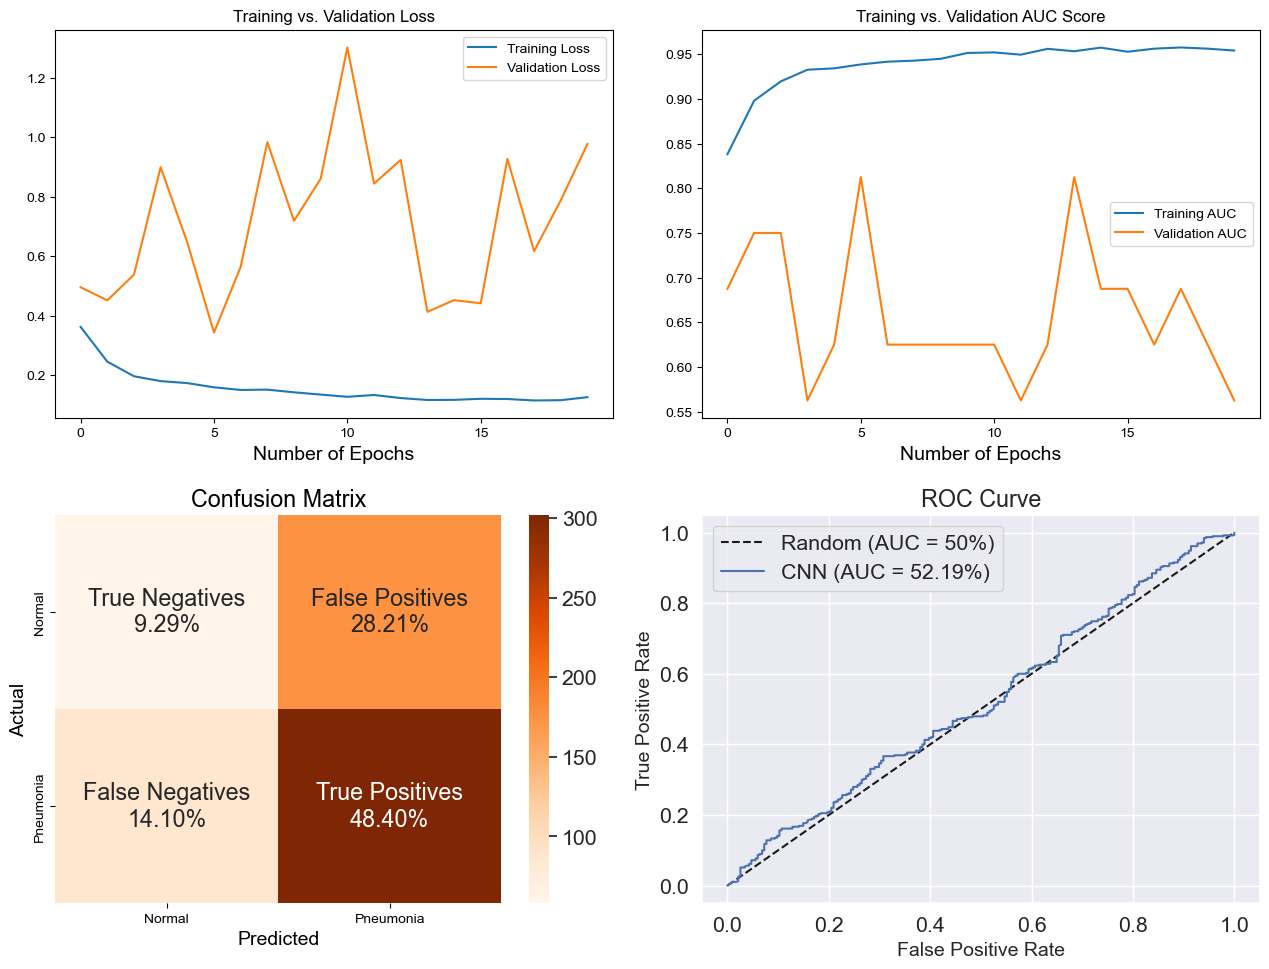

In [15]:
# 4. Plot charts
from tensorflow.keras.models import load_model
cnn = load_model("D:\Pneumonia _final\cnn_pneumonia_model.h5")
create_charts(cnn, history)

In [17]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [19]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
cnn = load_model("D:\Pneumonia _final\cnn_pneumonia_model.h5")

# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    """
    Load and preprocess an image for model prediction.
    - Reads the image in grayscale.
    - Resizes it to the target size.
    - Normalizes pixel values.
    - Expands dimensions for model compatibility.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    img = cv2.resize(img, target_size)  # Resize to target size (64x64)
    img = img / 255.0  # Normalize pixel values (0 to 1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (for model input)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (grayscale)
    return img

# Define the correct image path using a raw string (r"") to avoid escape character issues
image_path = r"C:\Users\HP\OneDrive\Desktop\SDP PROJECT\chest_xray\test\PNEUMONIA\person28_virus_62.jpeg"

# Preprocess the image
try:
    processed_image = preprocess_image(image_path)
    print("Image preprocessing successful!")
    print("Processed Image Shape:", processed_image.shape)  # Expected Output: (1, 64, 64, 1)
except FileNotFoundError as e:
    print(e)

# Make a prediction
prediction = cnn.predict(processed_image)

# Interpret the result
if prediction[0][0] > 0.5:
    print("Prediction: Pneumonia Detected")
else:
    print("Prediction: Normal Lungs")

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\HP\AppData\Local\Temp\ipykernel_15012\2907862520.py:4: SyntaxWarning: invalid escape sequence '\P'
  cnn = load_model("D:\Pneumonia _final\cnn_pneumonia_model.h5")


Image preprocessing successful!
Processed Image Shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Prediction: Pneumonia Detected
